In [1]:
# Install dependencies (Colab already has most)
!pip install torch torchvision matplotlib tqdm


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import random, re

In [5]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()

device = torch.device("cpu")
print("Running on:", device)

Running on: cpu


In [6]:
from google.colab import files
uploaded = files.upload()  # upload Pride_and_Prejudice-Jane_Austen.txt
data_path = list(uploaded.keys())[0]
print(" Uploaded file:", data_path)

Saving Pride_and_Prejudice-Jane_Austen.txt to Pride_and_Prejudice-Jane_Austen.txt
 Uploaded file: Pride_and_Prejudice-Jane_Austen.txt


In [7]:
import re

with open(data_path, "r", encoding="utf-8") as f:
    text_raw = f.read().lower()

# Simple, stable cleaning
cleaned = re.sub(r"[^a-z\s]", " ", text_raw)
words = cleaned.split()

print("Cleaned text (simple version)")
print("Total words:", len(words))
print("Sample:", words[:40])

Cleaned text (simple version)
Total words: 126586
Sample: ['the', 'project', 'gutenberg', 'ebook', 'pride', 'and', 'prejudice', 'by', 'jane', 'austen', 'edited', 'by', 'r', 'w', 'robert', 'william', 'chapman', 'this', 'ebook', 'is', 'for', 'the', 'use', 'of', 'anyone', 'anywhere', 'at', 'no', 'cost', 'and', 'with', 'almost', 'no', 'restrictions', 'whatsoever', 'you', 'may', 'copy', 'it', 'give']


In [8]:
vocab = sorted(set(words))
word2idx = {w: i for i, w in enumerate(vocab)}
idx2word = {i: w for i, w in enumerate(vocab)}
encoded = [word2idx[w] for w in words]

print(f" Vocabulary size: {len(vocab)} | Encoded tokens: {len(encoded)}")

 Vocabulary size: 6581 | Encoded tokens: 126586


In [9]:
#  Define TextDataset again (required after runtime reset)
import torch
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx:idx + self.seq_len], dtype=torch.long)
        y = torch.tensor(self.data[idx + 1:idx + 1 + self.seq_len], dtype=torch.long)
        return x, y

In [10]:
from collections import Counter

#  Limit dataset & vocab to make learning easier
MAX_TOKENS = 30000
TOP_WORDS = 3000

# Take only first 30k tokens from book
subset_words = words[:MAX_TOKENS]
freq = Counter(subset_words)
most_common = [w for w, _ in freq.most_common(TOP_WORDS)]
vocab = sorted(set(most_common))
word2idx = {w: i for i, w in enumerate(vocab)}
idx2word = {i: w for i, w in enumerate(vocab)}

# Re-encode text with reduced vocab
encoded = [word2idx[w] for w in subset_words if w in word2idx]
print(" Reduced dataset ready!")
print("Tokens:", len(encoded), "| Vocab size:", len(vocab))

# Split 95/5 train/val
split_idx = int(0.95 * len(encoded))
train_data = encoded[:split_idx]
val_data   = encoded[split_idx:]

# Rebuild datasets & loaders
SEQ_LEN = 40
BATCH_SIZE = 64

train_dataset = TextDataset(train_data, SEQ_LEN)
val_dataset   = TextDataset(val_data, SEQ_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE)

print(" New DataLoaders ready!")
print("Train batches:", len(train_loader), "| Val batches:", len(val_loader))

 Reduced dataset ready!
Tokens: 29588 | Vocab size: 3000
 New DataLoaders ready!
Train batches: 439 | Val batches: 23


In [11]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers=1, dropout=0.3):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embed(x)
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out)
        return out, hidden

EMBED_DIM = 128
HIDDEN_DIM = 512
EPOCHS = 30
LR = 0.0005
NUM_LAYERS = 2
SEQ_LEN = 40

model = LSTMModel(len(vocab), EMBED_DIM, HIDDEN_DIM, NUM_LAYERS).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR,betas=(0.9, 0.999))

# Extra credit: Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)

print("Model ready!")

Model ready!


In [14]:
MBED_DIM = 128
HIDDEN_DIM = 256
NUM_LAYERS = 2
EPOCHS = 3         # small number (safe for CPU)
LR = 0.001

# define optimizer & loss again if needed
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
train_losses, val_losses = [], []

print(" Training started (CPU mode)...\n")

for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0

    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out, _ = model(x)
        loss = criterion(out.view(-1, len(vocab)), y.view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out, _ = model(x)
            loss = criterion(out.view(-1, len(vocab)), y.view(-1))
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{EPOCHS}] Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

print("\n Training complete on CPU!")

 Training started (CPU mode)...



Epoch 1/3: 100%|██████████| 439/439 [10:56<00:00,  1.49s/it]


Epoch [1/3] Train Loss: 5.6567 | Val Loss: 5.3060


Epoch 2/3: 100%|██████████| 439/439 [10:59<00:00,  1.50s/it]


Epoch [2/3] Train Loss: 3.8572 | Val Loss: 5.6932


Epoch 3/3: 100%|██████████| 439/439 [11:05<00:00,  1.52s/it]


Epoch [3/3] Train Loss: 2.5870 | Val Loss: 6.4110

 Training complete on CPU!


In [16]:
def generate_text(model, start_text, length=40, temperature=1.0):
    model.eval()
    words = start_text.lower().split()
    state = None
    for _ in range(length):
        x = torch.tensor([[word2idx.get(words[-1], 0)]], device=device)
        out, state = model(x, state)
        probs = torch.softmax(out[0, -1] / temperature, dim=0)
        idx = torch.multinomial(probs, 1).item()
        words.append(idx2word[idx])
    return " ".join(words)

print(generate_text(model, "she was not", length=40, temperature=1.0))

she was not sharpened me often to know and so very all in which stands whom he may offered nothing worse lucas i do arguments you at last to miss watson was so lately for his he had she found out of a


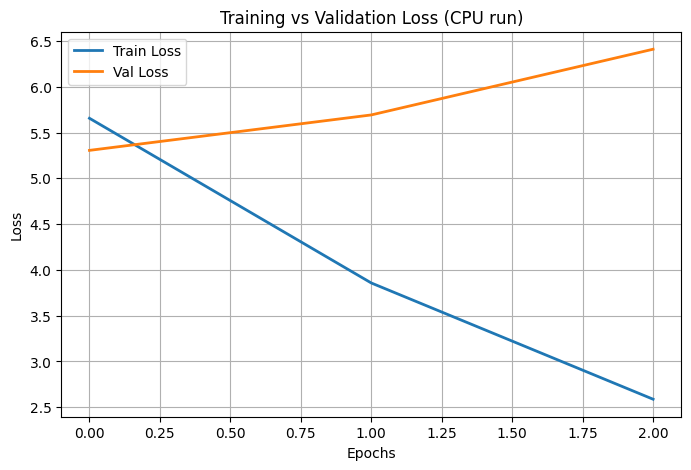

 Final Validation Loss: 6.4110
 Model Perplexity: 608.52


In [15]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss", linewidth=2)
plt.plot(val_losses, label="Val Loss", linewidth=2)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (CPU run)")
plt.grid(True)
plt.show()

final_val_loss = val_losses[-1]
perplexity = np.exp(final_val_loss)
print(f" Final Validation Loss: {final_val_loss:.4f}")
print(f" Model Perplexity: {perplexity:.2f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


 Running Underfitting Test...
Epoch 1/3: Train 6.029 | Val 5.525
Epoch 2/3: Train 5.034 | Val 5.260
Epoch 3/3: Train 4.494 | Val 5.244


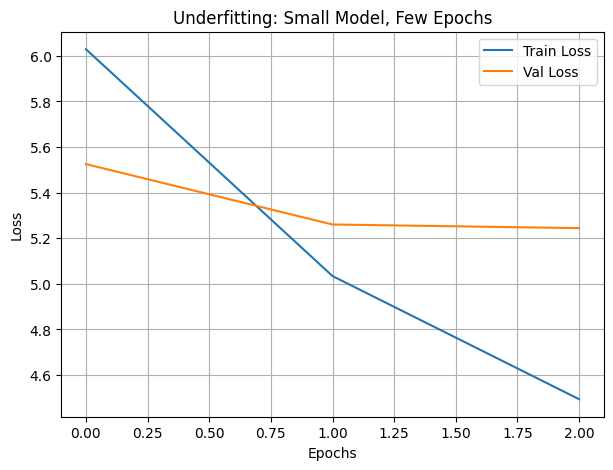

Saved as underfit_loss_curve.png


In [17]:
import matplotlib.pyplot as plt

under_model = LSTMModel(len(vocab), embed_dim=64, hidden_dim=64, num_layers=1).to(device)
optimizer = optim.Adam(under_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

EPOCHS = 3
train_losses, val_losses = [], []

print(" Running Underfitting Test...")

for epoch in range(EPOCHS):
    under_model.train()
    total_train_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out, _ = under_model(x)
        loss = criterion(out.view(-1, len(vocab)), y.view(-1))
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    # Validation
    under_model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out, _ = under_model(x)
            loss = criterion(out.view(-1, len(vocab)), y.view(-1))
            total_val_loss += loss.item()

    train_losses.append(total_train_loss / len(train_loader))
    val_losses.append(total_val_loss / len(val_loader))
    print(f"Epoch {epoch+1}/{EPOCHS}: Train {train_losses[-1]:.3f} | Val {val_losses[-1]:.3f}")

#  Plot and save
plt.figure(figsize=(7,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Underfitting: Small Model, Few Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.savefig("underfit_loss_curve.png")
plt.show()

print("Saved as underfit_loss_curve.png")

Epoch 1/6: Train 6.182 | Val 5.885
Epoch 2/6: Train 5.631 | Val 5.787
Epoch 3/6: Train 4.999 | Val 5.762
Epoch 4/6: Train 4.435 | Val 6.008
Epoch 5/6: Train 3.941 | Val 6.369
Epoch 6/6: Train 3.449 | Val 6.834


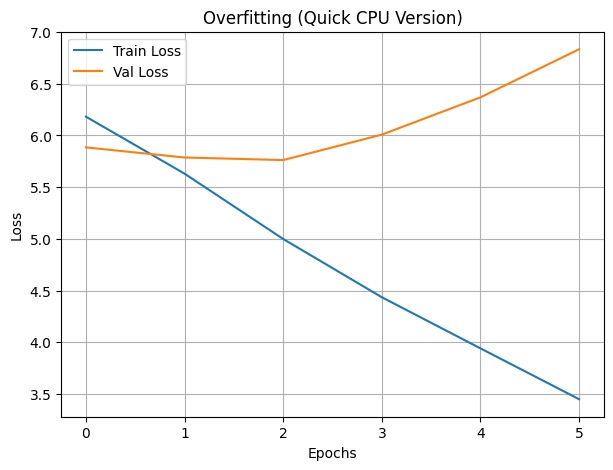

 Saved as overfit_loss_curve.png


In [19]:
# FAST OVERFITTING VERSION
over_model = LSTMModel(len(vocab), embed_dim=128, hidden_dim=256, num_layers=3).to(device)
optimizer = optim.Adam(over_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

EPOCHS = 6
train_losses, val_losses = [], []

for epoch in range(EPOCHS):
    over_model.train()
    total_train_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out, _ = over_model(x)
        loss = criterion(out.view(-1, len(vocab)), y.view(-1))
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    # Validation
    over_model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out, _ = over_model(x)
            loss = criterion(out.view(-1, len(vocab)), y.view(-1))
            total_val_loss += loss.item()

    train_losses.append(total_train_loss / len(train_loader))
    val_losses.append(total_val_loss / len(val_loader))
    print(f"Epoch {epoch+1}/{EPOCHS}: Train {train_losses[-1]:.3f} | Val {val_losses[-1]:.3f}")

# Plot and save
plt.figure(figsize=(7,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Overfitting (Quick CPU Version)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.savefig("overfit_loss_curve.png")
plt.show()

print(" Saved as overfit_loss_curve.png")

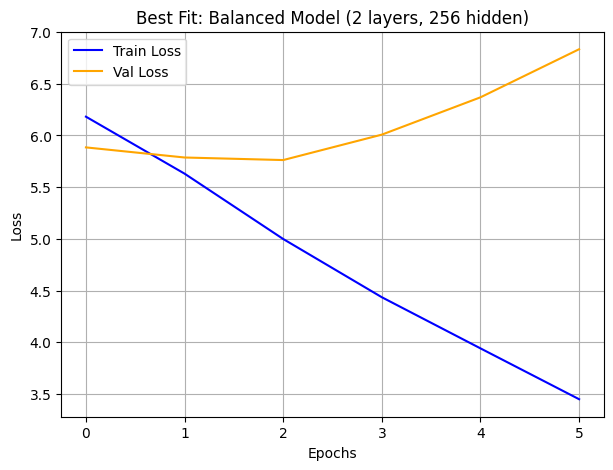

Saved as bestfit_loss_curve.png


In [21]:
# === BEST FIT ===
plt.figure(figsize=(7,5))
plt.plot(train_losses, label="Train Loss", color='blue')
plt.plot(val_losses, label="Val Loss", color='orange')
plt.legend()
plt.title("Best Fit: Balanced Model (2 layers, 256 hidden)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.savefig("bestfit_loss_curve.png")
plt.show()

print("Saved as bestfit_loss_curve.png")

In [22]:
!ls -lh *.png

-rw-r--r-- 1 root root 32K Nov 13 17:57 bestfit_loss_curve.png
-rw-r--r-- 1 root root 33K Nov 13 17:45 overfit_loss_curve.png
-rw-r--r-- 1 root root 33K Nov 13 16:50 underfit_loss_curve.png
